### Soil water permeability prediction using Knn regression

Knn regression is used to predict the soil water permeability using the spatial dataset. The model performance (Knn algorithm) is evaluated with using spatial leave-one-out cross-validation method with c-index value as metric. 

In [2]:
# import necessary libraries
import pandas as pd
import numpy as np
import operator
from numba import autojit #for fast compling


=== load dataset ===

In [3]:
#function to load dataset
def load_dataset(data):
    df = pd.read_csv(data, header=None)
    return df

In [5]:
#run load_dataset
df = load_dataset('Dataset/INPUT.csv')
print('Dimension of dataframe:', df.shape)
df.head(10)


Dimension of dataframe: (1691, 95)


,0,1,2,3,4,5,6,7,8,9,...,85,86,87,88,89,90,91,92,93,94
0,0,464,537,139,53,35,294,1151,236,211,...,0.2222,0.2222,0.0000,0.0000,0.0000,295.07,-0.0001,2.3657,0.0171,0.0347
1,0,328,404,107,38,36,211,848,392,475,...,0.2222,0.1111,0.0000,0.4444,0.0000,257.99,-0.0002,0.7365,0.0088,0.0347
2,1,182,219,56,21,36,116,437,108,128,...,0.0000,0.0000,0.0000,0.0000,0.0000,254.19,-0.0003,2.9106,0.0671,-4.1155
3,0,206,268,64,27,24,145,564,253,329,...,0.0000,0.0000,0.0000,0.0000,0.0000,253.84,0.0004,3.0498,0.0658,-4.3973
4,0,99,114,30,10,26,58,232,265,230,...,0.0000,0.0000,0.3333,0.2222,0.2222,257.65,-0.0001,2.0997,0.0303,-0.9330
5,0,384,465,114,47,45,272,974,157,102,...,0.2222,0.3333,0.4444,0.0000,0.0000,263.46,-0.0000,3.3676,0.0259,-1.4700
6,0,232,278,66,31,59,174,599,43,38,...,0.0000,0.3333,0.6667,0.0000,0.0000,264.07,-0.0001,2.9531,0.0215,-0.1728
7,0,1361,1640,456,142,103,723,3239,215,171,...,0.1111,0.2222,0.4444,0.2222,0.0000,290.28,-0.0006,2.7972,0.1487,10.1820
8,0,1361,1640,456,142,103,723,3239,215,171,...,0.1111,0.2222,0.4444,0.2222,0.0000,290.28,-0.0006,2.7972,0.1487,10.1820
9,0,1352,1648,460,145,104,715,3324,273,192,...,0.3333,0.0000,0.3333,0.0000,0.0000,294.45,0.0003,2.0202,0.1524,14.0770


=== normalize data with z-score ====

In [25]:
# Normalize the data
data = df.values# change to numpy array

for i in range(len(data.T)): # transpose and calcualte 'mean' and 'stdv' row-wise
    mean = np.mean(data.T[i])
    stdv = np.std(data.T[i])
    
    for j in range(len(df)) : # apply z-score in each element of df
        data[j][i]= (data[j][i] - mean)/stdv

data = pd.DataFrame(data)  # change to pandas dataframe 
data.tail(10) 

,0,1,2,3,4,5,6,7,8,9,...,85,86,87,88,89,90,91,92,93,94
1681,-0.272641,1.184331,1.239433,1.396467,1.111154,-0.154838,0.817396,1.292499,-0.336832,-0.116215,...,-0.414092,1.247497,-0.645254,-0.519918,-0.447089,-0.553792,-0.035919,4.349409,-0.833965,-0.920760
1682,-0.272641,-1.110957,-1.133975,-1.080954,-1.181823,-1.130514,-1.219890,-1.134568,-1.481942,-1.216954,...,2.754642,1.247497,-0.645254,-0.519918,-0.447089,-0.499910,0.333694,-0.868387,0.491144,-1.026513
1683,3.667832,-1.052404,-1.070028,-1.026704,-1.101835,-1.056878,-1.138399,-1.070570,-1.481942,-1.216954,...,-1.047724,1.247497,-0.645254,-0.519918,-0.447089,-0.546972,-0.651942,-0.863753,1.172569,-1.143825
1684,-0.272641,-1.110957,-1.133975,-1.080954,-1.181823,-1.130514,-1.219890,-1.134568,-1.481942,-1.216954,...,-0.414092,1.955874,2.098494,0.228921,-0.447089,-0.523782,-0.282329,-1.006913,-0.911542,-0.712998
1685,3.667832,-0.908948,-0.897864,-0.882037,-0.995185,-0.541427,-0.985602,-0.977593,-1.481942,-1.216954,...,0.853173,0.539119,-0.645254,-0.519918,-0.447089,-0.543334,0.210490,-0.641388,-0.592845,-0.494367
1686,-0.272641,-1.110957,-1.133975,-1.080954,-1.181823,-1.130514,-1.219890,-1.134568,-1.481942,-1.216954,...,0.219541,2.664890,-0.645254,-0.519918,-0.447089,-0.510368,0.333694,-0.605155,-0.869609,-1.089263
1687,-0.272641,-1.110957,-1.133975,-1.080954,-1.181823,-1.130514,-1.219890,-1.134568,-1.481942,-1.216954,...,-0.414092,1.247497,3.013076,-0.519918,-0.447089,2.831260,-0.405533,1.917122,4.751621,8.761618
1688,-0.272641,0.106951,0.130203,0.221048,0.017990,-0.872788,-0.094289,0.104323,-0.682183,-0.608471,...,-1.047724,3.373267,-0.645254,-0.519918,-0.447089,1.145896,1.072921,2.184146,3.527153,2.258910
1689,-0.272641,-1.110957,-1.133975,-1.080954,-1.181823,-1.130514,-1.219890,-1.134568,-1.481942,-1.216954,...,-0.414092,0.539119,-0.645254,-0.519918,-0.447089,3.594710,-0.405533,1.289039,4.411957,11.258372
1690,-0.272641,-1.110957,-1.133975,-1.080954,-1.181823,-1.130514,-1.219890,-1.134568,-1.481942,-1.216954,...,0.219541,-0.877636,-0.645254,-0.519918,0.756777,4.252668,0.826512,0.515351,5.565137,12.954723


In [26]:
# another way(normalize) using lambda 
zscore = lambda x: (x - x.mean()) / x.std()
newdf = df.copy()
newdf.iloc[:,:] = newdf.iloc[:,:].transform(zscore, axis=0) # apply funcion to each column
print('Data-frame with normalized features:')
newdf.tail(10)


Data-frame with normalized features:


,0,1,2,3,4,5,6,7,8,9,...,85,86,87,88,89,90,91,92,93,94
1681,-0.272560,1.183980,1.239067,1.396054,1.110825,-0.154792,0.817155,1.292117,-0.336733,-0.116181,...,-0.413969,1.247128,-0.645063,-0.519764,-0.446957,-0.553628,-0.035909,4.348122,-0.833718,-0.920487
1682,-0.272560,-1.110629,-1.133639,-1.080634,-1.181473,-1.130180,-1.219529,-1.134232,-1.481504,-1.216595,...,2.753827,1.247128,-0.645063,-0.519764,-0.446957,-0.499762,0.333595,-0.868131,0.490999,-1.026210
1683,3.666747,-1.052093,-1.069711,-1.026400,-1.101509,-1.056565,-1.138062,-1.070254,-1.481504,-1.216595,...,-1.047414,1.247128,-0.645063,-0.519764,-0.446957,-0.546810,-0.651749,-0.863498,1.172222,-1.143486
1684,-0.272560,-1.110629,-1.133639,-1.080634,-1.181473,-1.130180,-1.219529,-1.134232,-1.481504,-1.216595,...,-0.413969,1.955296,2.097873,0.228854,-0.446957,-0.523627,-0.282245,-1.006615,-0.911273,-0.712788
1685,3.666747,-0.908680,-0.897598,-0.881776,-0.994891,-0.541266,-0.985311,-0.977304,-1.481504,-1.216595,...,0.852921,0.538960,-0.645063,-0.519764,-0.446957,-0.543173,0.210427,-0.641198,-0.592670,-0.494221
1686,-0.272560,-1.110629,-1.133639,-1.080634,-1.181473,-1.130180,-1.219529,-1.134232,-1.481504,-1.216595,...,0.219476,2.664101,-0.645063,-0.519764,-0.446957,-0.510217,0.333595,-0.604976,-0.869351,-1.088941
1687,-0.272560,-1.110629,-1.133639,-1.080634,-1.181473,-1.130180,-1.219529,-1.134232,-1.481504,-1.216595,...,-0.413969,1.247128,3.012185,-0.519764,-0.446957,2.830423,-0.405413,1.916555,4.750215,8.759026
1688,-0.272560,0.106919,0.130165,0.220983,0.017985,-0.872530,-0.094261,0.104292,-0.681981,-0.608291,...,-1.047414,3.372270,-0.645063,-0.519764,-0.446957,1.145557,1.072604,2.183500,3.526110,2.258242
1689,-0.272560,-1.110629,-1.133639,-1.080634,-1.181473,-1.130180,-1.219529,-1.134232,-1.481504,-1.216595,...,-0.413969,0.538960,-0.645063,-0.519764,-0.446957,3.593647,-0.405413,1.288657,4.410652,11.255042
1690,-0.272560,-1.110629,-1.133639,-1.080634,-1.181473,-1.130180,-1.219529,-1.134232,-1.481504,-1.216595,...,0.219476,-0.877377,-0.645063,-0.519764,0.756553,4.251411,0.826268,0.515199,5.563491,12.950892


In [6]:
# read coordinates in pandas dataframe
df_cordin = pd.read_csv('COORDINATES.csv', header=None)
df_cordin.head()

,0,1
0,459140.0,7524200.0
1,461590.0,7549000.0
2,462040.0,7549300.0
3,462040.0,7549300.0
4,462130.0,7549400.0


In [7]:
# target variable(output)
df_target = pd.read_csv('OUTPUT.csv', names=['Target'])

# lets combine 'df_target' dataframe with 'data' dataframe
'''It will be easier to take target variable with repesct to test instance later in Knn. So, I don't have to modify
much Knn from scratch code'''

data_with_target = pd.concat([data, df_target], axis=1)
data_with_target.head()



,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,Target
0,-0.272641,0.247478,0.186771,0.175840,0.231291,-0.486200,0.277516,0.255260,0.662867,0.225630,...,0.539119,-0.645254,-0.519918,-0.447089,0.554097,0.087285,-0.109193,-0.913639,-0.461479,5.8359
1,-0.272641,-0.150684,-0.140341,-0.113494,-0.168647,-0.467791,-0.145221,-0.110611,2.080623,2.030569,...,-0.169259,-0.645254,2.475438,-0.447089,-0.288927,-0.035919,-1.481978,-1.087664,-0.461479,6.2592
2,3.667832,-0.578123,-0.595346,-0.574620,-0.621910,-0.467791,-0.629077,-0.606892,-0.500419,-0.341832,...,-0.877636,-0.645254,-0.519918,-0.447089,-0.375320,-0.159124,0.349947,0.134707,-0.809315,6.9041
3,-0.272641,-0.507859,-0.474831,-0.502287,-0.461935,-0.688698,-0.481374,-0.453540,0.817366,1.032383,...,-0.877636,-0.645254,-0.519918,-0.447089,-0.383278,0.703308,0.467238,0.107450,-0.832933,6.2065
4,-0.272641,-0.821119,-0.853593,-0.809704,-0.915198,-0.651880,-0.924484,-0.854429,0.926424,0.355530,...,-0.877636,2.098494,0.977760,1.960643,-0.296657,0.087285,-0.333328,-0.636876,-0.542584,7.0642


            ===  Knn from scratch implementation ====
            
The three functions are used to perfome Knn regression. The eculidan_dist() function calculates the eculidan distance between the two instances of data. The second function get_neighbours() finds the 'k' neighbours for the test instance, and the third function get_predic_val() finds the predict values by averaging the 'k' neigbours target variables.

In [8]:
#calculates eculidan distance between two data instances
@autojit
def eculidan_dist(data1, data2):
    
    distance = 0
    length = len(data2) -1 # since last variable is target 
        
    # loop through all  input variables (except target variables)
    for x in range(length):
        distance += np.power((data1[x]- data2[x]),2)
    return np.sqrt(distance)
    


In [9]:
# finds k nearest  neighbors of  test instance 
@autojit
def get_neighbours(trainingSet, testInstance, k):
        distance = []
        
        # find distance  between  a test instance to all training instances
        for x in range(len(trainingSet)):
            dist = eculidan_dist(trainingSet[x], testInstance) # call eculidan_dist function
            distance.append((trainingSet[x], dist)) 
        
        # sort the distance in ascending order
        distance.sort(key=operator.itemgetter(1))
        
    
        #store the  k neighbours
        neighbours = []
        for x in  range(k):
            # takes only neighbours from distance list and append 
            neighbours.append(distance[x][0]) 
        return neighbours
    

In [10]:
# finds average of target variables of k neighbours
@autojit
def get_predic_val(neighbors):
        total_neig = len(neighbors)
        predict_val = 0.0 # initilize predict value 
        
        #iterates over K neighbours
        for x in range(total_neig):
            predict_val += neighbors[x][-1] # take target variable(ouput) and sum them
            
        
        return  predict_val/total_neig # take average 
    
    

===  implementation of c-index ===

In [11]:
#implementation  of C_index
@autojit
def c_index (true_labels, predictions):
    n = 0
    h_sum =0
    
    for i in range(len(true_labels)):
        t = true_labels[i]
        p = predictions[i]
        
        
        for j in range(i+1, len(true_labels)):
            nt = true_labels[j]
            np = predictions[j]
            
            if( t!=nt):
                n += 1
                
                if(p < np and t <  nt) or (p > np and t > nt):
                    h_sum += 1
                
                elif(p == np):
                    h_sum += 0.5
                
    c_index = h_sum/n
    return c_index
    
    

In [12]:
# testing c-index implementation
true_labels = [-1, 1, 1, -1, 1]
predictions = [0.60, 0.80, 0.75, 0.75, 0.70]
c_index(true_labels, predictions)

0.75

                    === cross_validation start from here ===
                    
In this task, the dead zone radius (distance from test instance) is calcuated using eculidan distance between the test instance to all other data instances using co-ordinates. As mentioned in the lecture slides, the certain radius(=0 to 200 with 10 interval) is used and data points which lies in the given radius should be excluded/removed from training data set. The different k-values(=1, 3, 5, 7, 9) for Knn is used and find the optimal k using the c_index(higest) as metric. The following codes store all the c_index of k-values(=1, 3, 5, 7, 9) from each  radius(=0 to 200 with 10 interval) in 'c_index_values = {}' dictionary.

In [13]:

from scipy.spatial import distance
@autojit
def cross_validation(df_cordin, data_with_target):
    '''
    df_cordin = cordinates of all data points
    data_with_target = dataframe with input features and target variables
    
    '''
    
    print('Program runing ....')
    c_index_values = {} #store all the c-index values of k(=1,3,5,7,9) in given radius(as key) of(= 0 to 200) with 10 interval
    
    
    '''Find the data instances in the given radius and exclude them in training set'''
    for radius in range(0, 201, 10): # radius  interval of 10 meter
        optimal_k = 0
        higest_cindex = 0
        c_index_each_radius = {} # store each c-index values with corresponding k(as key)
    
        # k_values for KNN
        for k in range(1,10,2): 
            predicted_values = [] # store predicted values
            true_values = [] #store true values
        
        
            # calculate radius(using eculidian distance) from point p1 to p2(= all other co-ordinates)
            # split data into train and test set
            for x in range(len(df_cordin)): # iterates over all coordinates
                p1 = (df_cordin[0][x], df_cordin[1][x]) #base co-ordinate
                test_data= data_with_target.values[x] # test instance
                train_data = [] # store for train data
                true_values.append(data_with_target.values[x][-1]) # append target value
                
                
                # find p2(= all other co-ordinates) except p1
                for y in range(len(df_cordin)): # iterates over all coordinates 
                    if y != x: # check other cordinates than  p1(base cordinates)
                        p2 = (df_cordin[0][y], df_cordin[1][y]) # take next cordinates 
                        dst = distance.euclidean(p1, p2) # euclidan distance from p1 and p2, and  assign 'y'  row index 
                        
                        #exclude the data instance that lies in given radius and assign remaining as train_set
                        if  dst > radius: 
                            train_instance = data_with_target.values[y] # train_instance of 'y' row index
                            train_data.append(train_instance)
                            
           
                ''' == knn regression start from here ===  ''' 
                neighbours = get_neighbours(np.array(train_data), test_data, k) #call  get_neighbours()
                predic_val = get_predic_val(neighbours) # call get_predic_val()
                predicted_values.append(predic_val) #append predic_val
                
            
        
            '''=== c_index calculation start from here ==='''    
            c_val = c_index(true_values, predicted_values) # call c_index()
            c_index_each_radius[k] = c_val # assign c_index value with respect to k in Knn
            print(c_val)
        
            if c_val > higest_cindex: #check higest c_index 
                higest_cindex = c_val 
                optimal_k = k
            
        print('Optimal k for radius {0} is {1}\n'.format(radius,optimal_k))
        c_index_values[radius] = c_index_each_radius # append all c-index with k 
    
    
    return c_index_values           

 

In [ ]:
%%time
# run cross_validation function
c_index_values =  cross_validation(df_cordin, data_with_target )

Program runing ....
0.6744175302976639


In [17]:
# show the c_index values when k (= 1,3,5,7,9) in given radius(0,200 with interval of 10)   
c_index_values

{0: {1: 0.6744175302976639,
  3: 0.713814292853853,
  5: 0.7188966848608974,
  7: 0.7194381020510157,
  9: 0.7209395110656294},
 10: {1: 0.6632315081706048,
  3: 0.6979490542873102,
  5: 0.7065896806653517,
  7: 0.7098024859693502,
  9: 0.7116059266808431},
 20: {1: 0.6601579944255378,
  3: 0.7002501648400107,
  5: 0.7079682471242242,
  7: 0.7106189864894188,
  9: 0.7115698788653407},
 30: {1: 0.6607323096220369,
  3: 0.7010169683717167,
  5: 0.7030888428161254,
  7: 0.7048530859029942,
  9: 0.7053399064016721},
 40: {1: 0.6578691331305323,
  3: 0.6969925622507276,
  5: 0.6979147563657643,
  7: 0.7001668698876848,
  9: 0.704309218861337},
 50: {1: 0.6488498297003201,
  3: 0.6888013086406963,
  5: 0.6941461847412047,
  7: 0.6972690454958429,
  9: 0.7008290297607965},
 60: {1: 0.6449762644383751,
  3: 0.6856528994342943,
  5: 0.6927392700002379,
  7: 0.6954971028755658,
  9: 0.6992586749242996},
 70: {1: 0.6422856274909741,
  3: 0.6822770040135567,
  5: 0.6871613080247337,
  7: 0.6914712

====  plot the best c-index (to y-axis) from each radius ( to x-axis) ====

Radius:
 [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200] 

Best_cindex: 
 [0.7209395110656294, 0.7116059266808431, 0.7115698788653407, 0.7053399064016721, 0.704309218861337, 0.7008290297607965, 0.6992586749242996, 0.6943589718463061, 0.6909778267436993, 0.6886599172090171, 0.6868907744190702, 0.6546552778901599, 0.6340331275924679, 0.6214009930998181, 0.6192710221760561, 0.6163179011351912, 0.6171784989829616, 0.6169174148046629, 0.6161579608275739, 0.6158622287489378, 0.6147261975924259]


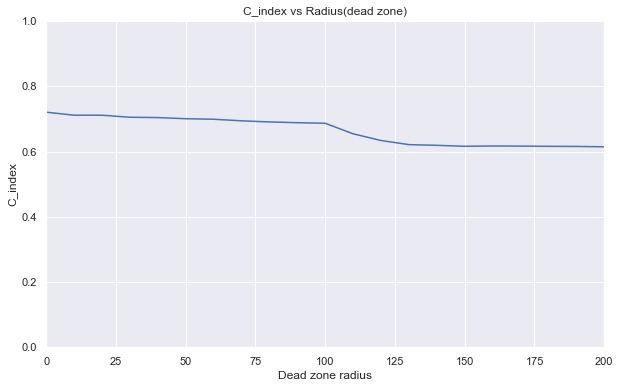

In [18]:
'''To plot, we have to have the list of radius that were used and best c-index from each radius'''

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline


radius= []
best_cindex = []

#iterates over c_index_values dictionary
for key, inner_dict in c_index_values.items():
    radius.append(key)# take radius and append
    best_cindex.append(max(inner_dict.values())) # take best c_index and append
    
print('Radius:\n', radius, '\n')
print('Best_cindex: \n', best_cindex)



''' ===  create the figure ==='''
plt.figure(figsize=(10,6))
ax = sns.lineplot(x= radius, y=best_cindex )# line graph
ax.set_title('C_index vs Radius(dead zone)',)
ax.set_xlabel('Dead zone radius')
ax.set_ylabel('C_index')

#control x and y limits
ax.set(ylim=(0, 1))
ax.set(xlim=(0, 200))
plt.show()




### Observation:

After observing the above graph, it shows that the model have better prediction in 0 meter radius, but of course this is not realistic result since the training data have more information of test instance in radius 0 meter. The closer the datapoints of the spatial dataset, they have similar properties which makes leakeage of informaiton ( of test instace) if we don't exclude the closer data points from training dataset. 

As we keep increasing  the dead zone radius, the prediction  result goes on decreasing. And, my laptaop took more than 7 hours to compute this dataset. Laptop is MacBook Pro (Retina, 13-inch, Mid 2014) with processor of 2,6 GHz Intel Core i5 and 8 GB 1600 MHz DDR3. I have implemented knn from scratch in this task. 